<a href="https://colab.research.google.com/github/chazhurd/LocalizationLab/blob/dev/Colab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Colab 1: Learn to use Apache Spark with Python (30 points)

In this lab you will learn how to use [Apache Spark](https://spark.apache.org) on a Colab enviroment.

### **Setup**

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 46kB/s 
     |████████████████████████████████| 204kB 44.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=020245e954157fe87dfbe138bc8031b4c73d8c563512185c4ed02300b6d6f749
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Now we authenticate a Google Drive client to download files. Please follow the instruction to enter the authoriztion code.


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now download the file we will be processing in our Spark job.

In [0]:
id='11xoXxyX1rFB-EabHt1cqRkf5nULcs25t'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('game-clicks.csv.gz') 

id='1ji6ulH3Q56wGIdCSBgglUQn4-irJXVYX'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('ad-clicks.csv.gz') 


If you executed the cells above, you should be able to see the files under the "Files/content" folder on the left panel.

Import libraries.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize the Spark context.


In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **Load `game-clicks` and `ad-clicks` datasets**



Load the datasets:

In [0]:
gameclicks = spark.read.csv("game-clicks.csv.gz", header='true')
adclicks = spark.read.csv("ad-clicks.csv.gz", header='true')

Check the schemas:

In [8]:
gameclicks.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- clickId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- isHit: string (nullable = true)
 |-- teamId: string (nullable = true)
 |-- teamLevel: string (nullable = true)



In [9]:
adclicks.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- txId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- teamId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- adId: string (nullable = true)
 |-- adCategory: string (nullable = true)



Get a formatted sample with `show()`:

In [10]:
gameclicks.show()

+-------------------+-------+------+-------------+-----+------+---------+
|          timestamp|clickId|userId|userSessionId|isHit|teamId|teamLevel|
+-------------------+-------+------+-------------+-----+------+---------+
|2016-05-26 15:06:55|    105|  1038|         5916|    0|    25|        1|
|2016-05-26 15:07:09|    154|  1099|         5898|    0|    44|        1|
|2016-05-26 15:07:14|    229|   899|         5757|    0|    71|        1|
|2016-05-26 15:07:14|    322|  2197|         5854|    0|    99|        1|
|2016-05-26 15:07:20|     22|  1362|         5739|    0|    13|        1|
|2016-05-26 15:07:27|    107|  1071|         5939|    0|    27|        1|
|2016-05-26 15:07:30|    289|  2359|         5764|    0|    85|        1|
|2016-05-26 15:07:30|    301|  1243|         5900|    0|    86|        1|
|2016-05-26 15:07:47|    274|  1628|         5896|    0|    82|        1|
|2016-05-26 15:07:48|     66|   453|         5662|    0|    20|        1|
|2016-05-26 15:07:49|    124|  2336|  

Find the number of records:

In [11]:
print("In total there are {0} game clicks".format(gameclicks.count()))

print("In total there are {0} ad clicks".format(adclicks.count()))


In total there are 755806 game clicks
In total there are 16323 ad clicks


## **Question 1: How many users in each team?**
Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Use DataFrame API to group the users by `teamID` and count how many distinct users in each team. Sort the result in descending order.

In [14]:
team_counts = gameclicks.groupBy("teamId").agg(countDistinct("userId")).orderBy('count(DISTINCT userId)', ascending = False)

team_counts.show()

+------+----------------------+
|teamId|count(DISTINCT userId)|
+------+----------------------+
|    22|                    33|
|    53|                    26|
|    18|                    25|
|    64|                    25|
|    35|                    23|
|    27|                    21|
|    86|                    21|
|    71|                    21|
|    72|                    21|
|    84|                    20|
|     9|                    20|
|    99|                    20|
|    36|                    19|
|    13|                    19|
|    74|                    19|
|    77|                    19|
|    70|                    18|
|    97|                    18|
|    75|                    18|
|    66|                    18|
+------+----------------------+
only showing top 20 rows



# Now rewrite the above question using pure SQL:

In [15]:
gameclicks.registerTempTable("gameclicks")

query = """SELECT count(distinct userId) as count, teamId
FROM gameclicks
GROUP BY teamId
ORDER BY count desc"""

team_counts = spark.sql(query)
team_counts.show()

+-----+------+
|count|teamId|
+-----+------+
|   33|    22|
|   26|    53|
|   25|    64|
|   25|    18|
|   23|    35|
|   21|    72|
|   21|    71|
|   21|    27|
|   21|    86|
|   20|    84|
|   20|    99|
|   20|     9|
|   19|    77|
|   19|    36|
|   19|    13|
|   19|    74|
|   18|    66|
|   18|   104|
|   18|    51|
|   18|    75|
+-----+------+
only showing top 20 rows



##The `team_counts` Dataframe is small enough to be moved to Pandas:

In [16]:
team_counts_pd = team_counts.toPandas()
team_counts_pd.head()

,count,teamId
0,33,22
1,26,53
2,25,64
3,25,18
4,23,35


##Plot a histogram using the number of users by team:

Text(0, 0.5, 'NUmber of Users')

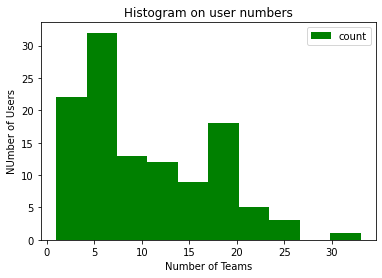

In [17]:
histoplot = team_counts_pd.plot.hist(stacked = True, bins =10, color = 'green')
histoplot.set_title("Histogram on user numbers")
histoplot.set_xlabel("Number of Teams")
histoplot.set_ylabel("NUmber of Users")


----

## **Questions 2: Now use the `ad-clicks` dataset to find the number of ad clicks in each hour.**

Keywords: `group by`, `parse timestamp`, `plot`

In [20]:
timestamp_only = adclicks.selectExpr(["to_timestamp(timestamp) as timestamp"])

click_count_by_hour = timestamp_only.groupBy(hour('timestamp').alias("hour"))\
.agg(count('*').alias("ClickCount")).sort("hour")

click_count_by_hour.show(24) 

+----+----------+
|hour|ClickCount|
+----+----------+
|   0|       605|
|   1|       728|
|   2|       633|
|   3|       552|
|   4|       614|
|   5|       691|
|   6|       710|
|   7|       704|
|   8|       726|
|   9|       799|
|  10|       705|
|  11|       648|
|  12|       714|
|  13|       647|
|  14|       623|
|  15|       695|
|  16|       707|
|  17|       662|
|  18|       686|
|  19|       603|
|  20|       675|
|  21|       756|
|  22|       696|
|  23|       744|
+----+----------+



# Use line plot to show the number of clicks by hour:

Text(0.5, 0, 'hour')

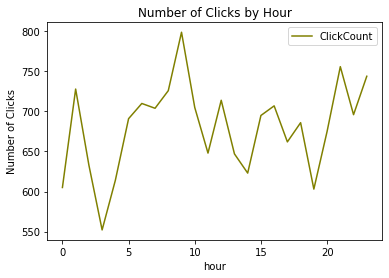

In [23]:
chrpd = click_count_by_hour.toPandas()
lp = chrpd.plot(kind = "line", x = "hour", y = "ClickCount", color = "olive")
lp.set_title("Number of Clicks by Hour")
lp.set_ylabel("Number of Clicks")
lp.set_xlabel("hour")


## Question 3: Use `map` and `reduce` with RDD

Keywords: `RDD map reduce`

Now we want to find the number of clicks of each `adCategorory` using `map` and `reduce` with RDD. Since we only care the `adCategory`, let's select this column only.

In [24]:
categoryOnly = adclicks.select("adCategory")
categoryOnly.show(10)


+-----------+
| adCategory|
+-----------+
|electronics|
|     movies|
|  computers|
|    fashion|
|   clothing|
|      games|
|     movies|
|electronics|
|electronics|
|  computers|
+-----------+
only showing top 10 rows



Now use explicit Map/Reduce format with RDDs.

First we emit a pair in the format (`adCategory`, 1):

In [29]:
all_categories = categoryOnly.rdd.map(lambda row: (row.adCategory,1))
all_categories.take(5)

[('electronics', 1),
 ('movies', 1),
 ('computers', 1),
 ('fashion', 1),
 ('clothing', 1)]

Then, we sum counters in the reduce step, and we sort by count:

In [35]:
category_counts_rdd = all_categories.reduceByKey(lambda a,b: a+b).sortBy(lambda r: -r[1])
category_counts_rdd.take(3)

[('computers', 2638), ('games', 2601), ('clothing', 2340)]

Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`

In [38]:
category_counts_with_schema = category_counts_rdd.map(lambda r: Row(adCategory=r[0], NumOfCategories =r[1]))
category_counts = spark.createDataFrame(category_counts_with_schema)
category_counts.show()

+---------------+-----------+
|NumOfCategories| adCategory|
+---------------+-----------+
|           2638|  computers|
|           2601|      games|
|           2340|   clothing|
|           2074|     sports|
|           1727|    fashion|
|           1692|     movies|
|           1588|   hardware|
|           1097|electronics|
|            566| automotive|
+---------------+-----------+



Now use SparkSQL to verify the above result:

In [44]:
#print(adclicks.count())

adclicks.registerTempTable("adclicks")

query = """SELECT adCategory, count(adID) as NumOfCategories FROM adclicks
GROUP BY adCategory
ORDER BY NumOfCategories desc
"""

category_counts = spark.sql(query)
category_counts.show()


+-----------+---------------+
| adCategory|NumOfCategories|
+-----------+---------------+
|  computers|           2638|
|      games|           2601|
|   clothing|           2340|
|     sports|           2074|
|    fashion|           1727|
|     movies|           1692|
|   hardware|           1588|
|electronics|           1097|
| automotive|            566|
+-----------+---------------+



#Congratulations on the first Spark assignment!